<a href="https://colab.research.google.com/github/jabhavya/Convolve/blob/main/Convolve_top40_as_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
import pandas as pd
import numpy as np

In [46]:
df = pd.read_excel('/content/FileAndResults_Problem2.xlsx')

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   File Changed   351 non-null    object
 1   Component      351 non-null    object
 2   Coder          351 non-null    object
 3   Tester         337 non-null    object
 4   Category       351 non-null    object
 5   Sanity name    351 non-null    object
 6   nets Tested    351 non-null    object
 7   Sanity Result  351 non-null    object
dtypes: object(8)
memory usage: 22.1+ KB


In [48]:
df.describe().transpose()

,count,unique,top,freq
File Changed,351,176,cpp/csyu/category/fnf,2
Component,351,45,asr1001-forge-cgn,70
Coder,351,7,patrick,130
Tester,337,18,manishakang,109
Category,351,11,PD-asr1001,146
Sanity name,351,25,vistra-cxr,122
nets Tested,351,14,"asr1001-PX,asr1001-X64",105
Sanity Result,351,3,Pass,210


In [49]:
new_df = pd.get_dummies(df,columns=['Coder','Tester','Component','Category','Sanity name','nets Tested'])

In [50]:
new_df.drop(columns='File Changed',inplace =True)

In [51]:
new_df.head()

,Sanity Result,Coder_Alex,Coder_Batukbaj,Coder_abhimanyu,Coder_actalivineo,Coder_chris,Coder_daffoil,Coder_patrick,Tester_akafsg,Tester_arvenugo,...,"nets Tested_NCS560,SPITFIRE,NCS540L","nets Tested_NCS5K,NCS560",nets Tested_NCS6K,"nets Tested_SPITFIRE,NCS4K","nets Tested_SPITFIRE,NCS540L",nets Tested_XRV9K,"nets Tested_asr1001-PX,asr1001-X64",nets Tested_asr1001-X64,"nets Tested_asr1001-X64,asr1001-PX",nets Tested_saraja-PX
0,Pass,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Aborted,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Fail,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Aborted,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Aborted,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
Label = new_df.loc[:,['Sanity Result']]

In [53]:
Label.head()

,Sanity Result
0,Pass
1,Aborted
2,Fail
3,Aborted
4,Aborted


In [54]:
Label.replace('Pass', 2, inplace = True)
Label.replace('Aborted', 1,  inplace = True) 
Label.replace('Fail', 0,  inplace = True)

In [64]:
X= new_df.drop(columns = ['Sanity Result'])
y = Label

In [65]:
# from imblearn.over_sampling import RandomOverSampler

# ros =  RandomOverSampler()
# X_ros, y_ros = ros.fit_resample(X, y)

In [66]:
from sklearn.model_selection import StratifiedShuffleSplit 

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=0)

for train,test in sss.split(X,y):    
    X_train_SS = X.iloc[train]
    y_train_SS = y.iloc[train]
    X_test_SS = X.iloc[test]
    y_test_SS = y.iloc[test]

In [67]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [68]:
from sklearn.linear_model import LogisticRegression,RidgeClassifier, Perceptron
from sklearn.tree import DecisionTreeClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

classifiers = {
    "Logistic Regression": LogisticRegression(class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced'),
    "k-Nearest Neighbors": KNeighborsClassifier(),
    "Linear SVM": SVC(class_weight='balanced'),
    "Gradient Boosting Classifier": GradientBoostingClassifier(),
    "Random Forest": RandomForestClassifier(),
    'RidgeClassifier': RidgeClassifier(class_weight='balanced'),
    'AdaBoost': AdaBoostClassifier(n_estimators=100),
    'MNB': MultinomialNB(),
    'Perceptron': Perceptron(class_weight='balanced'),
    'xgboost': XGBClassifier(n_estimators=300),
    'catboost': CatBoostClassifier(verbose=0)
        }

In [69]:
no_classifiers = len(classifiers.keys())

from sklearn.metrics import f1_score
from time import process_time 

def batch_classify(X_train_tranformed, y_train, X_test_tranformed, y_test, verbose = True):
    df_results = pd.DataFrame(data=np.zeros(shape=(no_classifiers,3)), columns = ['Classifier', 'f1', 'Training time'])
    count = 0
    for key, classifier in classifiers.items():
        t_start = process_time()  
        classifier.fit(X_train_tranformed, y_train)
        t_stop = process_time() 
        t_elapsed = t_stop - t_start
        y_predicted = classifier.predict(X_test_tranformed)
        
        df_results.loc[count,'Classifier'] = key
        df_results.loc[count,'f1'] = f1_score(y_test, y_predicted, average = 'macro')
        df_results.loc[count,'Training time'] = t_elapsed
        if verbose:
            print("trained {c} in {f:.2f} s".format(c=key, f=t_elapsed))
        count+=1

    return df_results

In [70]:
df_results = batch_classify(X_train_SS, y_train_SS,X_test_SS, y_test_SS)
print(df_results.sort_values(by='f1', ascending=False))

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ra

trained Logistic Regression in 0.04 s
trained Decision Tree in 0.01 s
trained k-Nearest Neighbors in 0.00 s
trained Linear SVM in 0.03 s
trained Gradient Boosting Classifier in 0.45 s


<ipython-input-69-3c1466a05748>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier.fit(X_train_tranformed, y_train)


trained Random Forest in 0.24 s
trained RidgeClassifier in 0.03 s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:1059: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


trained AdaBoost in 0.33 s
trained MNB in 0.00 s
trained Perceptron in 0.01 s


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for examp

trained xgboost in 0.65 s
trained catboost in 2.27 s
                      Classifier        f1  Training time
4   Gradient Boosting Classifier  0.804282       0.451108
5                  Random Forest  0.760458       0.241018
11                      catboost  0.742711       2.267141
10                       xgboost  0.741224       0.650400
8                            MNB  0.713381       0.004195
2            k-Nearest Neighbors  0.696252       0.004105
3                     Linear SVM  0.693567       0.026114
6                RidgeClassifier  0.682204       0.029112
0            Logistic Regression  0.673534       0.040090
9                     Perceptron  0.659447       0.007640
1                  Decision Tree  0.655951       0.005130
7                       AdaBoost  0.458912       0.331049


In [71]:
results=pd.DataFrame()
results['columns']=X_train_SS.columns
results['importances'] = classifiers['xgboost'].feature_importances_
results.sort_values(by='importances',ascending=False,inplace=True)

results[:40]

,columns,importances
22,Tester_vermaa,0.144140
66,Component_surflow-acl,0.079609
57,Component_ncs560-ogr,0.076624
10,Tester_edurok,0.069212
23,Tester_yung,0.029056
68,Component_surflow-li,0.027078
18,Tester_pinkasr,0.026808
74,Category_PD-asr1001,0.024154
71,Category_PD-CRS,0.024024
80,Category_analyzedata,0.022825


In [72]:
top40 = results[0:40]

In [73]:
top40

,columns,importances
22,Tester_vermaa,0.144140
66,Component_surflow-acl,0.079609
57,Component_ncs560-ogr,0.076624
10,Tester_edurok,0.069212
23,Tester_yung,0.029056
68,Component_surflow-li,0.027078
18,Tester_pinkasr,0.026808
74,Category_PD-asr1001,0.024154
71,Category_PD-CRS,0.024024
80,Category_analyzedata,0.022825


Text(0, 0.5, 'Importances')

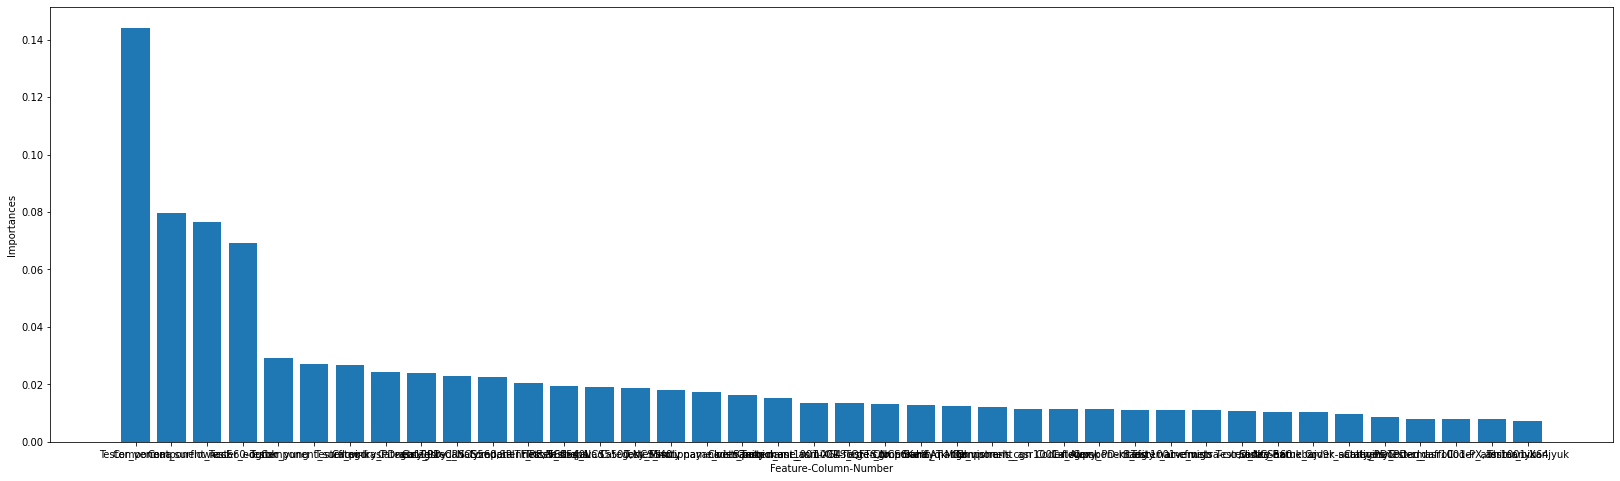

In [74]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize =(28,8))
plt.bar(top40['columns'],top40['importances'])
plt.xlabel('Feature-Column-Number')
plt.ylabel('Importances')

In [75]:
h =  top40['columns']

In [76]:
X_new  = X[h]

In [77]:
# Fitting_and_predicting_model
def kfold_model_f1_score(model,X,y):
  kfold_validation =KFold(5)
  results = cross_val_score(model,X_new,y,cv=kfold_validation,scoring ="f1_score", average='macro')
  return np.mean(results)

In [78]:
# from xgboost import XGBClassifier
# from sklearn.model_selection import KFold
# from sklearn.model_selection import cross_val_score

# xgb_model = XGBClassifier()
# kfold_validation =KFold(5)
# results = cross_val_score(xgb_model,X_new,y_ros,cv=kfold_validation,scoring ="f1")
# results.mean()

In [83]:
ros1 =  RandomOverSampler()
X_ros1, y_ros1 = ros.fit_resample(X_new, y)

In [85]:
from sklearn.model_selection import StratifiedShuffleSplit 

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=0)

for train,test in sss.split(X_ros1, y_ros1):    
    X_train_SS1 = X_ros1.iloc[train]
    y_train_SS1 = y_ros1.iloc[train]
    X_test_SS1 = X_ros1.iloc[test]
    y_test_SS1 = y_ros1.iloc[test]

In [86]:
df_results = batch_classify(X_train_SS1, y_train_SS1,X_test_SS1, y_test_SS1)
print(df_results.sort_values(by='f1', ascending=False))

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ra

trained Logistic Regression in 0.03 s
trained Decision Tree in 0.00 s
trained k-Nearest Neighbors in 0.00 s
trained Linear SVM in 0.03 s
trained Gradient Boosting Classifier in 0.41 s
trained Random Forest in 0.15 s
trained RidgeClassifier in 0.01 s


<ipython-input-69-3c1466a05748>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier.fit(X_train_tranformed, y_train)
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:1059: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


trained AdaBoost in 0.18 s
trained MNB in 0.00 s
trained Perceptron in 0.01 s


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for examp

trained xgboost in 0.40 s
trained catboost in 1.47 s
                      Classifier        f1  Training time
5                  Random Forest  0.808264       0.152193
11                      catboost  0.803433       1.469378
1                  Decision Tree  0.799672       0.003665
10                       xgboost  0.751910       0.396538
3                     Linear SVM  0.731023       0.031755
4   Gradient Boosting Classifier  0.728836       0.412727
6                RidgeClassifier  0.716556       0.006100
2            k-Nearest Neighbors  0.708244       0.002661
0            Logistic Regression  0.690784       0.032546
9                     Perceptron  0.681159       0.006993
8                            MNB  0.641390       0.003513
7                       AdaBoost  0.555437       0.179151
